In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras 
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.regularizers import l2
from keras.optimizers import SGD, RMSprop
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras import models
from keras.models import Model

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10104196113176534083
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8033033579916696987
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [4]:
train_dir = '/content/drive/MyDrive/Elbrus/hack/TRAIN/'

In [5]:
TRAIN = pd.read_csv(train_dir+'train_4_net.csv')
TRAIN.head()

,year,month,day,delta_stage_max,lat,lon,distance_from_source,drainage_area,z_null,aet_12,aet_11,aet_10,aet_9,aet_8,aet_7,aet_6,aet_5,aet_4,aet_3,aet_2,aet_1,Cm,J,K,N,O,X,Z
0,1985,1,1,0.0,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0
1,1985,1,2,0.0,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0
2,1985,1,3,0.0,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0
3,1985,1,4,-1.0,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0
4,1985,1,5,0.0,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0


In [6]:
TEST = pd.read_csv(train_dir+'test_4_net.csv')
TEST.head()

,year,month,day,lat,lon,distance_from_source,drainage_area,z_null,aet_12,aet_11,aet_10,aet_9,aet_8,aet_7,aet_6,aet_5,aet_4,aet_3,aet_2,aet_1,Cm,J,K,N,O,X,Z
0,1993,4,111,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0
1,1993,4,112,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0
2,1993,4,113,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0
3,1993,4,114,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0
4,1993,4,115,57.77,108.07,1140.0,92200,249.38,0,0,8,24,50,71,80,66,34,6,0,0,1,0,0,0,0,0,0


In [7]:
list(TRAIN.columns)

['year',
 'month',
 'day',
 'delta_stage_max',
 'lat',
 'lon',
 'distance_from_source',
 'drainage_area',
 'z_null',
 'aet_12',
 'aet_11',
 'aet_10',
 'aet_9',
 'aet_8',
 'aet_7',
 'aet_6',
 'aet_5',
 'aet_4',
 'aet_3',
 'aet_2',
 'aet_1',
 'Cm',
 'J',
 'K',
 'N',
 'O',
 'X',
 'Z']

In [8]:
features = [
            'year',
            'month',
            'day',
            'lat',
            'lon',
            'distance_from_source',
            'drainage_area',
            'z_null',
            'aet_12',
            'aet_11',
            'aet_10',
            'aet_9',
            'aet_8',
            'aet_7',
            'aet_6',
            'aet_5',
            'aet_4',
            'aet_3',
            'aet_2',
            'aet_1',
            'Cm',
            'J',
            'K',
            'N',
            'O',
            'X',
            'Z'
    
]

target = [ 
            'delta_stage_max',
]

In [41]:
X = TRAIN[features]
y = TRAIN[target]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [70]:
input_data = Input(27)

dense_1 = Dense(200, activation='relu')(input_data)
dense_1 = Dropout(0.1)(dense_1)
dense_1 = Dense(50, activation='relu')(dense_1)
dense_1 = BatchNormalization()(dense_1)
dense_1 = Dense(10, activation='relu')(dense_1)

dense_2 = Dense(200, activation='LeakyReLU')(input_data)
dense_2 = Dropout(0.1)(dense_2)
dense_2 = Dense(50, activation='LeakyReLU')(dense_2)
dense_2 = BatchNormalization()(dense_2)
dense_2 = Dense(10, activation='LeakyReLU')(dense_2)


dense_3 = Dense(200, activation='tanh')(input_data)
dense_3 = Dropout(0.1)(dense_3)
dense_3 = Dense(50, activation='tanh')(dense_3)
dense_3 = BatchNormalization()(dense_3)
dense_3 = Dense(10, activation='tanh')(dense_3)



mid_1 = keras.layers.concatenate([dense_1, dense_2, dense_3], axis = 1)

# flat_1 = Flatten()(mid_1) 

dense_4 = Dense(1000, activation='relu')(mid_1)

output = Dense(1, activation='linear')(dense_4)


model = Model([input_data], output)

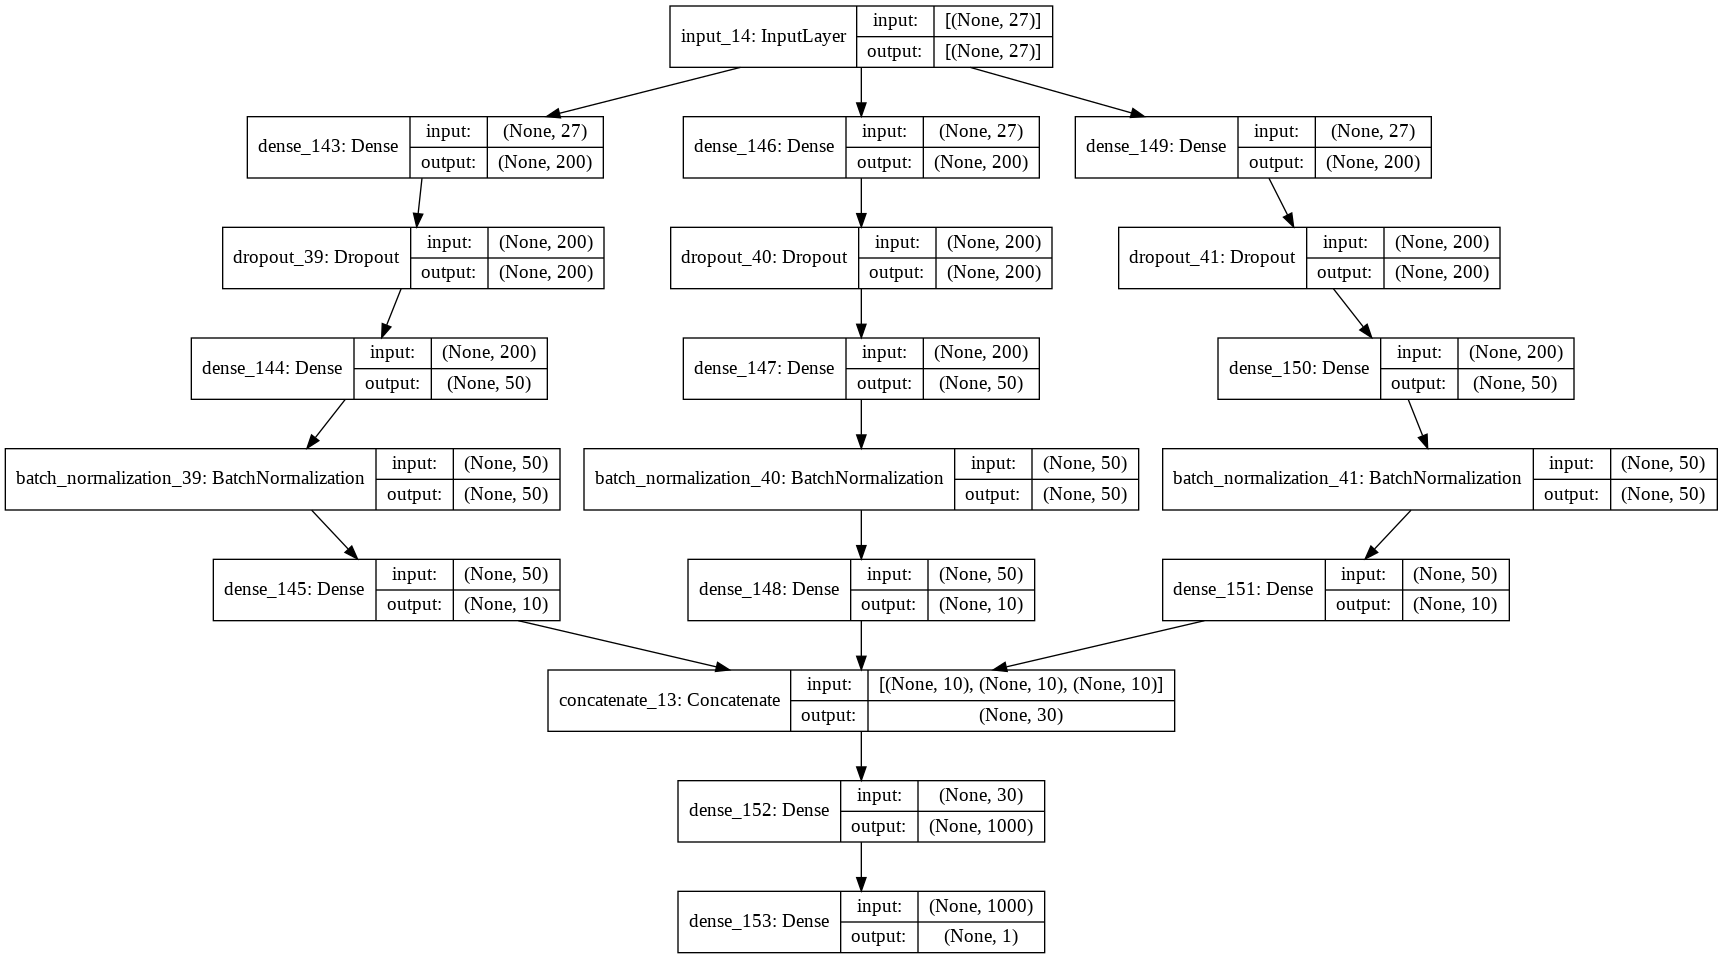

In [71]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [72]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 27)]         0                                            
__________________________________________________________________________________________________
dense_143 (Dense)               (None, 200)          5600        input_14[0][0]                   
__________________________________________________________________________________________________
dense_146 (Dense)               (None, 200)          5600        input_14[0][0]                   
__________________________________________________________________________________________________
dense_149 (Dense)               (None, 200)          5600        input_14[0][0]                   
___________________________________________________________________________________________

In [98]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
    loss='mse',
    loss_weights=None,
    weighted_metrics=None
)


In [99]:
model.fit(
    x=X_train,
    y=y_train,
    validation_data = (X_test, y_test),
    batch_size=200,
    epochs=2000,
    verbose=2,
    callbacks=None,
    initial_epoch=0,
    workers=-1,
)


Epoch 1/2000
1406/1406 - 8s - loss: 978.4037 - root_mean_squared_error: 33.5861 - val_loss: 807.5457 - val_root_mean_squared_error: 31.1338
Epoch 2/2000
1406/1406 - 6s - loss: 977.4356 - root_mean_squared_error: 31.6572 - val_loss: 807.8693 - val_root_mean_squared_error: 31.0603
Epoch 3/2000
1406/1406 - 6s - loss: 976.6451 - root_mean_squared_error: 31.0386 - val_loss: 807.2562 - val_root_mean_squared_error: 31.0329
Epoch 4/2000
1406/1406 - 6s - loss: 975.5502 - root_mean_squared_error: 31.1173 - val_loss: 807.1452 - val_root_mean_squared_error: 31.0152
Epoch 5/2000
1406/1406 - 6s - loss: 977.6403 - root_mean_squared_error: 31.1260 - val_loss: 807.0920 - val_root_mean_squared_error: 31.0108
Epoch 6/2000
1406/1406 - 6s - loss: 976.5473 - root_mean_squared_error: 31.0869 - val_loss: 807.6532 - val_root_mean_squared_error: 31.0052
Epoch 7/2000
1406/1406 - 6s - loss: 977.2056 - root_mean_squared_error: 30.9327 - val_loss: 807.1697 - val_root_mean_squared_error: 31.0027
Epoch 8/2000
1406/14

In [100]:
model.save('/content/drive/MyDrive/Elbrus/hack/model3/')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Elbrus/hack/model3/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Elbrus/hack/model3/assets


In [101]:
preds = model.predict(TEST[features])

In [89]:
TEST['delta_stage_max'] = preds
TEST['date'] = test['date']
TEST['station_id'] = test['station_id']

In [86]:
test = pd.read_csv('cp4_test.csv')
test.columns

Index(['year', 'station_id', 'month', 'day', 'date', 'delta_stage_max'], dtype='object')

In [84]:
TEST.columns

Index(['year', 'month', 'day', 'lat', 'lon', 'distance_from_source',
       'drainage_area', 'z_null', 'aet_12', 'aet_11', 'aet_10', 'aet_9',
       'aet_8', 'aet_7', 'aet_6', 'aet_5', 'aet_4', 'aet_3', 'aet_2', 'aet_1',
       'Cm', 'J', 'K', 'N', 'O', 'X', 'Z', 'delta_stage_max'],
      dtype='object')

In [102]:
TEST[[ 'year', 'month', 'day', 'station_id', 'date', 'delta_stage_max']].to_csv('/content/drive/MyDrive/Elbrus/hack/model3/submit.csv', index=False)

,station_id,date,delta_stage_max,year,day
0,3019,1993-04-21,4.220223,1993,111
1,3019,1993-04-22,4.351358,1993,112
2,3019,1993-04-23,4.584540,1993,113
3,3019,1993-04-24,5.015503,1993,114
4,3019,1993-04-25,5.742451,1993,115
5,3019,1993-04-26,6.875784,1993,116
6,3019,1993-04-27,8.103795,1993,117
7,3019,1997-04-21,4.191300,1997,111
8,3019,1997-04-22,4.322358,1997,112
9,3019,1997-04-23,4.529010,1997,113
